## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
# !wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip ml-1m.zip
# !cat ml-1m/README

--2025-03-02 11:56:42--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  5.30MB/s    in 1.1s    

2025-03-02 11:56:45 (5.30 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any

In [2]:
import pandas as pd
import numpy as np
from typing import Union

In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [ ]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
print((df_train['user_id'].nunique(), df_train['user_id'].max()))
print((df_train['item_id'].nunique(), df_train['item_id'].max()))

(5365, np.int64(5364))
(3010, np.int64(3009))


##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = df.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    return result.values #shape ~ [n_users, n_items]

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    n_users = df['user_id'].max() + 1
    n_items = df['item_id'].max() + 1
    rows = df['user_id'].values
    cols = df['item_id'].values
    data = df['rating'].values
    return coo_array((data, (rows, cols)), shape=(n_users, n_items), dtype=float)

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from scipy.sparse.linalg import svds

def make_svd(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    U, S, V = None, None, None

    if isinstance(interactions, np.ndarray):
        U, S, V = np.linalg.svd(interactions, full_matrices=False)
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]
    else:
        U, S, V = svds(interactions, k=min(interactions.shape) - 1 if n_singular_values == -1 else n_singular_values)

    S = np.diag(S)
    
    return U, S, V

In [15]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [16]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [17]:
def make_svd_recommendations(interactions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантных айтемов среди тех, с которыми он еще не взаимодействовал.

    U, S, V = make_svd(interactions, n_singular_values)

    interactions_svd = U @ S @ V
    
    if isinstance(interactions, np.ndarray):
        already_interacted_mask = interactions != 0
    else:
        already_interacted_mask = np.zeros(interactions.shape, dtype=bool)
        already_interacted_mask[interactions.row, interactions.col] = True

    masked_interactions_svd = np.where(already_interacted_mask, -np.inf, interactions_svd)

    top_items = np.argsort(masked_interactions_svd, axis=1)[:, ::-1]

    recommendations = top_items[:, :top_k]

    return recommendations  # shape ~ [n_users, top_k]

In [18]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [19]:
def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=float)

def ndcg_metric(gt_items, predicted):
    at = len(predicted)
    relevance = np.array([1 if x in gt_items else 0 for x in predicted])
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_

def calculate_ndcg(recomendations, df_test):
    ndcg = 0.0

    for user_id in df_test['user_id'].unique():
        gt_items = df_test[df_test['user_id'] == user_id]['item_id'].tolist()
        ndcg += ndcg_metric(gt_items, recomendations[user_id])

    return ndcg / df_test['user_id'].nunique()

In [20]:
import time
import matplotlib.pyplot as plt

def plot_graphs(interactions: Union[np.ndarray, coo_array], top_k: int = 100):
    ndcg_history = []
    time_history = []

    for n_singular_values in [1, 10, 50, 200, 1000]:
        start_time = time.time()
        
        recommendations = make_svd_recommendations(interactions, n_singular_values, top_k)
        
        ndcg_score = calculate_ndcg(recommendations, df_test)
        
        end_time = time.time()
        
        ndcg_history.append(ndcg_score)
        time_history.append(end_time - start_time)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].plot([1, 10, 50, 200, 1000], ndcg_history, marker='o', color='g')
    ax[0].set_title('Значение NDCG в зависимости от n_singular_values')
    ax[0].set_xlabel('n_singular_values')
    ax[0].set_ylabel('NDCG')
    ax[0].grid()
    
    ax[1].plot([1, 10, 50, 200, 1000], time_history, marker='o', color='r')
    ax[1].set_title('Зависимость времени выполнения от n_singular_values')
    ax[1].set_xlabel('n_singular_values')
    ax[1].set_ylabel('Time (seconds)')
    ax[1].grid()
    
    plt.tight_layout()
    plt.show()


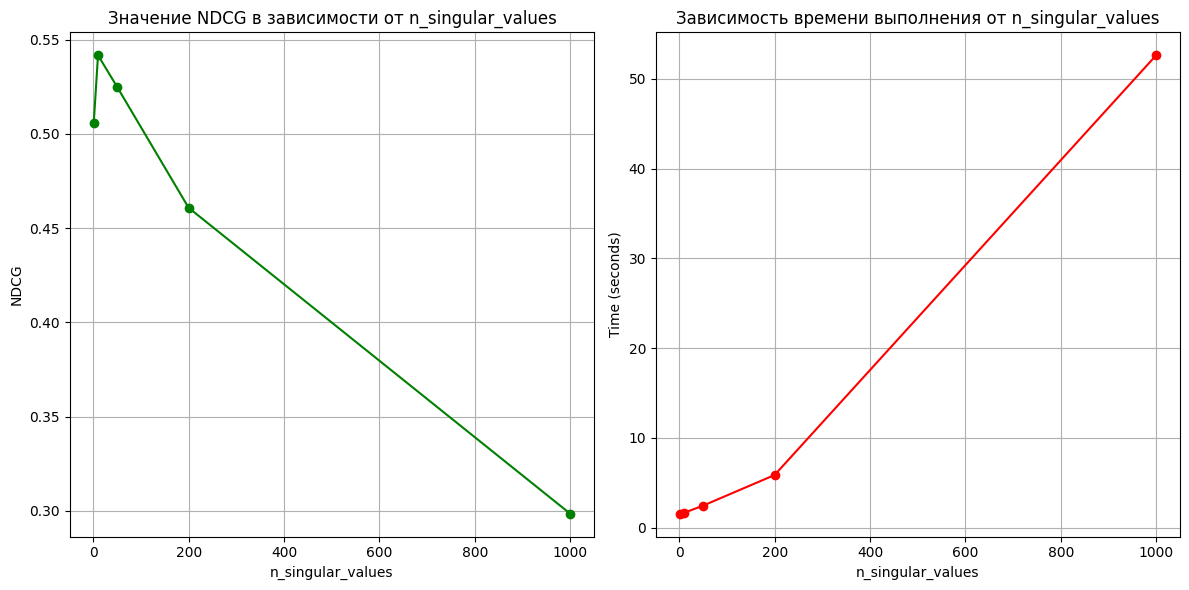

In [21]:
plot_graphs(coo_interactions)

Видим, что для данного датасета чем меньше сингулярных значений. тем лучше. При этом с увеличением количества значений время работы также заметно увеличивается.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [22]:
from implicit.cpu.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

def make_als_recommendations(
    interactions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
    iterations: int = 15,
    show_progress: bool = True,
    return_model: bool = False,
    use_gpu: bool = False
):
    
    interactions = csr_matrix(interactions)
    
    als_model = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha, iterations=iterations, num_threads=4)
    
    if use_gpu:
        als_model = als_model.to_gpu()
    
    als_model.fit(interactions, show_progress=show_progress)
    
    recommendations = als_model.recommend(np.arange(interactions.shape[0]), user_items=interactions, N=top_k, filter_already_liked_items=True)[0]
    
    if return_model:
        return recommendations, als_model
    return recommendations  # shape ~ [n_users, top_k]

/home/chaichuk/miniconda3/envs/main-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
recs = make_als_recommendations(coo_interactions)
assert recs.shape == (coo_interactions.shape[0], 100)

/home/chaichuk/miniconda3/envs/main-env/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
100%|██████████| 15/15 [00:01<00:00,  9.18it/s]


Посчитаем метрику

In [24]:
calculate_ndcg(recs, df_test)

np.float64(0.5008599954099113)

В целом, метрика с базовыми параметрами сравнима с той, которая была у SVD

Попробуем подобрать гиперпараметры

In [25]:
import optuna

def objective(trial):
    n_factors = trial.suggest_int("n_factors", 5, 120, step=5)
    alpha = trial.suggest_float("alpha", 1.0, 10.0)
    regularization = trial.suggest_float("regularization", 0.001, 10.0, log=True)
    iterations = trial.suggest_int("iterations", 10, 50, step=5)

    recs = make_als_recommendations(coo_interactions, n_factors=n_factors, alpha=alpha, regularization=regularization, iterations=iterations, show_progress=False, use_gpu=True)
    return calculate_ndcg(recs, df_test)

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=200)

[I 2025-03-02 12:00:20,961] A new study created in memory with name: no-name-a07d22eb-c995-45f2-a4d1-fdf2e0c57280
[I 2025-03-02 12:00:23,460] Trial 0 finished with value: 0.5184831062488025 and parameters: {'n_factors': 45, 'alpha': 9.556428757689245, 'regularization': 0.8471801418819978, 'iterations': 35}. Best is trial 0 with value: 0.5184831062488025.
[I 2025-03-02 12:00:24,905] Trial 1 finished with value: 0.5237097310069209 and parameters: {'n_factors': 20, 'alpha': 2.403950683025824, 'regularization': 0.0017073967431528124, 'iterations': 45}. Best is trial 1 with value: 0.5237097310069209.
[I 2025-03-02 12:00:26,589] Trial 2 finished with value: 0.5096195688047714 and parameters: {'n_factors': 75, 'alpha': 7.372653200164409, 'regularization': 0.0012087541473056963, 'iterations': 50}. Best is trial 1 with value: 0.5237097310069209.
[I 2025-03-02 12:00:27,876] Trial 3 finished with value: 0.5003605071138442 and parameters: {'n_factors': 100, 'alpha': 2.9110519961044856, 'regulariza

In [26]:
study.best_value

0.5397647093063869

In [27]:
study.best_params

{'n_factors': 5,
 'alpha': 6.09412295947113,
 'regularization': 4.758507010828268,
 'iterations': 25}

После подбора гиперпараметров качество удалось улучшить. Но оно все еще сравнимо с качеством SVD-предсказаний

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

Получим названия и id фильмов из файла

In [29]:
movie_titles = {}
with open('/home/chaichuk/AI_Masters/RecSys/hw2/ml-1m/movies.dat', 'r', encoding='ISO-8859-1') as f:
    for line in f:
        parts = line.strip().split('::')
        movie_id = int(parts[0]) - 1
        title = parts[1]
        movie_titles[movie_id] = title

In [30]:
sparse_interactions = csr_matrix(interactions)

Сделаем предсказания. Возьмем не очень много, чтобы не все объяснять

In [31]:
recs, model = make_als_recommendations(sparse_interactions, n_factors=10, alpha=5.0, regularization=10.0, top_k=5, return_model=True)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 19.61it/s]


Выберем несколько юзеров для объяснения

In [50]:
user_ids = np.random.randint(interactions.shape[0], size=5)
user_ids

array([1993, 2174, 3116, 1674, 3815])

In [51]:
for user_id in user_ids:
    print('User:', user_id, end='\n\n')
    user_recs = recs[user_id]
    recs_to_movie = [movie_titles[item] for item in user_recs]



    max_length = 0
    explanations = []
    for item_id in user_recs:
        explanation = model.explain(user_id, sparse_interactions, item_id)[1]
        explanations.append([movie_titles[item] if item in movie_titles else None for item, score in explanation ])
        for m in explanations[-1]:
            if len(m) > max_length:
                max_length = len(m)

    for m in recs_to_movie:
        if len(m) > max_length:
                max_length = len(m)

    print('Recommended:', end='\n\n')

    for m in recs_to_movie:
        print(m + ' ' * (max_length - len(m) + 4), end='')
    print('\n')

    print('Explanations:', end='\n\n')

    for i in range(7):
        expl_i = [e[i] for e in explanations]
        for e in expl_i:
            print(e + ' ' * (max_length - len(e) + 4), end='')
        print()

    print()
    print('-' * 200)
    print()


User: 1993

Recommended:

Mrs. Doubtfire (1993)                   Priest (1994)                           Lawrence of Arabia (1962)               Urban Legend (1998)                     Gordy (1995)                            

Explanations:

Dead Man on Campus (1998)               Dead Man on Campus (1998)               Dead Man on Campus (1998)               Dead Man on Campus (1998)               Ladybird Ladybird (1994)                
With Honors (1994)                      Broken Arrow (1996)                     Broken Arrow (1996)                     Love and Death on Long Island (1997)    With Honors (1994)                      
Inventing the Abbotts (1997)            Love and Death on Long Island (1997)    Inventing the Abbotts (1997)            Money Pit, The (1986)                   Inventing the Abbotts (1997)            
Broken Arrow (1996)                     Inventing the Abbotts (1997)            Program, The (1993)                     Toy Story (1995)                  

Можем действительно наблюдать, что на рекомендации влияют близкие по жанрам фильмы. Например, для фильма Dead Man on Campus (1998), высокие скоры имеют другие околокриминальные фильмы

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

Сделаем первую модификацию и посмотрим на качество

In [52]:
interactions_1 = interactions.copy()
interactions_1[interactions_1 != 0] = 1

svd_recommendations = make_svd_recommendations(interactions_1, n_singular_values=5, top_k=100)
print(f'SVD recs NDCG@100: {calculate_ndcg(svd_recommendations, df_test)}')

als_recommendations = make_als_recommendations(interactions_1, n_factors=5, alpha=10.0, top_k=100, show_progress=False)
print(f'ALS recs NDCG@100: {calculate_ndcg(als_recommendations, df_test)}')

SVD recs NDCG@100: 0.5345716738697296
ALS recs NDCG@100: 0.5282282190180604


Видим, что качество осталось примерно на том же уровне, что и сбазовыми данными. И сами модели близки по качеству

Теперь попробуем вторую модификацию

In [57]:
interactions_2 = interactions.copy()
interactions_2[interactions_2 < 4] = 0
interactions_2[interactions_2 >= 4] = 1

svd_recommendations = make_svd_recommendations(interactions_2, n_singular_values=5, top_k=100)
print(f'SVD recs NDCG@100: {calculate_ndcg(svd_recommendations, df_test)}')

als_recommendations = make_als_recommendations(interactions_2, n_factors=5, alpha=10.0, top_k=100, show_progress=False)
print(f'ALS recs NDCG@100: {calculate_ndcg(als_recommendations, df_test)}')

SVD recs NDCG@100: 0.49500719018543277
ALS recs NDCG@100: 0.49777927791791693


Качество обеих моделей на такой модификации снизилось. Скорее всего потому, что стало меньше информации о взаимодействиях.

Перейдем к третьей модификации

In [58]:
interactions_3 = interactions.copy()
interactions_3[(interactions_3 != 0) & (interactions_3 < 4)] = -1
interactions_3[interactions_3 >= 4] = 1

svd_recommendations = make_svd_recommendations(interactions_3, n_singular_values=5, top_k=100)
print(f'SVD recs NDCG@100: {calculate_ndcg(svd_recommendations, df_test)}')

als_recommendations = make_als_recommendations(interactions_3, n_factors=5, alpha=15.0, top_k=100, show_progress=False)
print(f'ALS recs NDCG@100: {calculate_ndcg(als_recommendations, df_test)}')

SVD recs NDCG@100: 0.5259910286168683
ALS recs NDCG@100: 0.5335671955545584


Качество вернулось на прежний уровень. ALS работает чуть лучше

Наконец, 4 модификация

In [59]:
df_train_bin = df_train.copy()
df_train_bin['month'] = df_train_bin['datetime'].apply(lambda x: x.month)
df_train_bin['month_diff'] = 11 - df_train_bin['month']
df_train_bin['rating'] = df_train_bin['rating'].apply(lambda x: -1 if x < 4 else 1)
df_train_bin['rating'] = df_train_bin['rating'] * 0.8**df_train_bin['month_diff']

interactions_4 = df_to_matrix(df_train_bin)

In [60]:
svd_recommendations = make_svd_recommendations(interactions_4, n_singular_values=5, top_k=100)
print(f'SVD recs NDCG@100: {calculate_ndcg(svd_recommendations, df_test)}')

als_recommendations = make_als_recommendations(interactions_4, n_factors=5, alpha=15.0, top_k=100, show_progress=False)
print(f'ALS recs NDCG@100: {calculate_ndcg(als_recommendations, df_test)}')

SVD recs NDCG@100: 0.5272501666689094
ALS recs NDCG@100: 0.5449737389302433


Качество все еще на уровне обычных данных. Но тут отрыв ALS сильнее. И это без подбора гиперпараметров

Итоге сравнения: SVD и ALS показывают сходное качество (по крайней мере на этих данных), но ALS все же показывает лучшее качество, и имеет еще потенциал для настройки гиперпараметров. В целом ALS является более гибким подходом.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [75]:
import numpy as np
from scipy.sparse import csr_matrix, diags, eye
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
        self.n_factors = n_factors
        self.alpha = alpha
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None
        self.scores = None

    def fit(self, interactions: csr_matrix, n_iterations: int = 10, show_progress=True):
        n_users, n_items = interactions.shape
        self.user_factors = np.random.normal(size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(size=(n_items, self.n_factors))
        self.scores = self.user_factors @ self.item_factors.T
        
        Cui = interactions.multiply(self.alpha)
        Cui.data = 1.0 + Cui.data
        
        for _ in tqdm(range(n_iterations), disable=not show_progress):
             
            YTY = self.item_factors.T @ self.item_factors

            for u, Cuii in enumerate(Cui):
                Cuii = diags(Cuii.toarray().ravel())

                if Cuii.sum() == 0:
                    continue

                A = YTY + self.item_factors.T @ ((Cuii - eye(n_items)) @ self.item_factors) + self.reg_coef * eye(self.n_factors)
                b = self.item_factors.T @ (Cuii @ self.scores[u])
                self.user_factors[u] = scipy.linalg.solve(A, b)
            
            XTX = self.user_factors.T @ self.user_factors

            for i, Ciuu in enumerate(Cui.T):
                Ciuu = diags(Ciuu.toarray().ravel())

                if Ciuu.sum() == 0:
                    continue
                
                A = XTX + self.user_factors.T @ ((Ciuu - eye(n_users)) @ self.user_factors) + self.reg_coef * eye(self.n_factors)
                b = self.user_factors.T @ (Ciuu @ self.scores[:, i])
                self.item_factors[i] = scipy.linalg.solve(A, b)

            self.scores = self.user_factors @ self.item_factors.T
                
    def predict(self, interactions: csr_matrix, top_k: int = 10):
        scores = self.scores
        interactions = interactions.toarray()

        already_interacted_mask = interactions != 0

        masked_scores = np.where(already_interacted_mask, -1e10, scores)
        top_items = np.argsort(masked_scores, axis=1)[:, ::-1]

        return top_items[:, :top_k]

In [62]:
recommendations = make_als_recommendations(interactions, n_factors=10, alpha=10.0, top_k=100)
calculate_ndcg(recommendations, df_test)

100%|██████████| 15/15 [00:00<00:00, 19.68it/s]


np.float64(0.5018541606859438)

In [78]:
als_model = iALS(n_factors=10, alpha=40.0)
    
als_model.fit(csr_matrix(interactions), n_iterations=10)

100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


In [80]:
recommendations = als_model.predict(csr_matrix(interactions), top_k=100)
calculate_ndcg(recommendations, df_test)

np.float64(0.21064062669877368)